In [1]:
import glob
import os
import re
from nltk.tokenize import word_tokenize
import nltk
import tarfile
nltk.download('punkt')
!pip install tensorflow==1.15
!pip install "tensorflow_hub>=0.6.0"
!pip3 install tensorflow_text==1.15

import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn import preprocessing
import keras
import numpy as np

from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K
!pip install keras_metrics
import keras_metrics
!pip install transformers
from transformers import BertTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 412.3MB 39kB/s 
     |████████████████████████████████| 3.8MB 40.0MB/s 
     |████████████████████████████████| 512kB 43.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=ec7cc90f5c8f6fb70fe15a510655dcea61c397d7339e3b7f22ac645c00727bbf
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorfl

Using TensorFlow backend.


     |████████████████████████████████| 645kB 3.3MB/s 
     |████████████████████████████████| 1.0MB 8.6MB/s 
     |████████████████████████████████| 890kB 19.8MB/s 
     |████████████████████████████████| 3.8MB 21.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=0bd2e6e211638dcfc751726fb3c1691790dbff428cacc03fdfe00cd38a2b365a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
!pip install bert-tensorflow
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
from tensorflow import keras
import os
import re

     |████████████████████████████████| 71kB 2.4MB/s 



In [0]:
!pip install keras --upgrade

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


# **loading data and preprocess**

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
link = 'https://drive.google.com/open?id=1g6zN3aoYZKhc9IcqsBg8SWfJwHwayr3j'
fluff, id = link.split('=')
print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('aclImdb_v1.tar.gz')  
if os.path.isdir('aclImdb'):
    print("Dataset directory exists, taking no action")
else:    
    if not os.path.isfile('aclImdb_v1.tar.gz'):
        print("Downloading dataset")
        # !wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
        # # wget.download('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz')
    else:
        print("Dataset already downloaded")
    
    print("Unpacking dataset")
    # !tar -xf aclImdb_v1.tar.gz 
    tar = tarfile.open("aclImdb_v1.tar.gz")
    tar.extractall()
    tar.close()
    print("Dataset unpacked in aclImdb")


1g6zN3aoYZKhc9IcqsBg8SWfJwHwayr3j
Dataset already downloaded
Unpacking dataset
Dataset unpacked in aclImdb


In [5]:
nltk.download('stopwords')
positive_sample_file_list = glob.glob(os.path.join('aclImdb/train/pos', "*.txt"))
# positive_sample_file_list = positive_file_list[:SAMPLE_SIZE]

negative_sample_file_list = glob.glob(os.path.join('aclImdb/train/neg', "*.txt"))
# negative_sample_file_list = negative_file_list[:SAMPLE_SIZE]

# load doc into memory
# regex to clean markup elements 
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding='utf8')
    # read all text
    text = re.sub('<[^>]*>', ' ', file.read())
    #text = file.read()
    # close the file
    file.close()
    return text


positive_strings = [load_doc(x) for x in positive_sample_file_list]
negative_strings = [load_doc(x) for x in negative_sample_file_list]

positive_labels = [1 for x in positive_sample_file_list]
negative_labels = [0 for x in negative_sample_file_list]

# positive_tokenized = [word_tokenize(s) for s in positive_strings]
# negative_tokenized = [word_tokenize(s) for s in negative_strings]

sentences = positive_strings + negative_strings
labels = positive_labels + negative_labels

import pandas as pd
df_train = pd.DataFrame(
    {'sentences': sentences,
     'sentiment': labels
    })
# df_train = df_train.sample(5000)
df_train = df_train.sample(frac=1).reset_index(drop=True)

train_sentences = df_train.sentences.values
train_labels = df_train.sentiment.values

from nltk.tokenize.treebank import TreebankWordDetokenizer
train_sentences = [word_tokenize(s) for s in train_sentences]

pre_sen = []
for tokens in train_sentences:
  tokens = [w.lower() for w in tokens]
  import string
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  words = [word for word in stripped if word.isalpha()]
  # filter out stop words
  from nltk.corpus import stopwords
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  pre_sen.append(words)
train_sentences = pre_sen

t_sen = []
for s in train_sentences:
  if(len(s)<128):
    t_sen.append(TreebankWordDetokenizer().detokenize(s))
  else:
    t_sen.append(TreebankWordDetokenizer().detokenize(s[0:127]))

train_sentences = t_sen

df_train = pd.DataFrame(
    {'sentences': train_sentences,
     'sentiment': train_labels
    })

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-cased', do_lower_case=True)
train_input_ids = []
train_input_masks = []
train_segment_ids = []
for sent in train_sentences:
      encoded_dict = tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 128,pad_to_max_length = True,return_attention_mask = True)
      train_input_ids.append(encoded_dict['input_ids'])
      train_input_masks.append(encoded_dict['attention_mask'])
      train_segment_ids.append(encoded_dict['token_type_ids'])

In [0]:
len(train_input_ids)

25000

In [0]:
positive_sample_file_list = glob.glob(os.path.join('aclImdb/test/pos', "*.txt"))
# positive_sample_file_list = positive_file_list[:SAMPLE_SIZE]

negative_sample_file_list = glob.glob(os.path.join('aclImdb/test/neg', "*.txt"))
# negative_sample_file_list = negative_file_list[:SAMPLE_SIZE]

positive_strings = [load_doc(x) for x in positive_sample_file_list]
negative_strings = [load_doc(x) for x in negative_sample_file_list]

positive_labels = [1 for x in positive_sample_file_list]
negative_labels = [0 for x in negative_sample_file_list]

# positive_tokenized = [word_tokenize(s) for s in positive_strings]
# negative_tokenized = [word_tokenize(s) for s in negative_strings]

sentences = positive_strings + negative_strings
labels = positive_labels + negative_labels

import pandas as pd
df_test = pd.DataFrame(
    {'sentences': sentences,
     'sentiment': labels
    })
df_test = df_test.sample(5000)
df_test = df_test.sample(frac=1).reset_index(drop=True)

test_sentences = df_test.sentences.values
test_labels = df_test.sentiment.values

from nltk.tokenize.treebank import TreebankWordDetokenizer
test_sentences = [word_tokenize(s) for s in test_sentences]

pre_sen = []
for tokens in test_sentences:
  tokens = [w.lower() for w in tokens]
  import string
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  words = [word for word in stripped if word.isalpha()]
  # filter out stop words
  from nltk.corpus import stopwords
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  pre_sen.append(words)
test_sentences = pre_sen

# t_sen = []
# for s in test_sentences:
#   if(len(s)<128):
#     t_sen.append(TreebankWordDetokenizer().detokenize(s))
#   else:
#     t_sen.append(TreebankWordDetokenizer().detokenize(s[0:127]))

# test_sentences = t_sen

# df_test = pd.DataFrame(
#     {'sentences': test_sentences,
#      'sentiment': test_labels
#     })

In [0]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-cased', do_lower_case=True)
test_input_ids = []
test_input_masks = []
test_segment_ids = []
for sent in test_sentences:
      encoded_dict = tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 128,pad_to_max_length = True,return_attention_mask = True)
      test_input_ids.append(encoded_dict['input_ids'])
      test_input_masks.append(encoded_dict['attention_mask'])
      test_segment_ids.append(encoded_dict['token_type_ids'])

In [0]:
df_train.head()

,sentences,sentiment
0,wonderful yet another movie america someone vi...,0
1,disgrace checking hoping would undiscovered ja...,0
2,wow ever said edward wood jr never influenced ...,0
3,budgetstarved italian actionscifi hybrid featu...,0
4,one thing sure everyone seen film agree creepy...,1


In [0]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            'https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1',
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )
        trainable_vars = self.bert.variables
        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]
        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
        # Add non-trainable weights
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)
        
        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids)
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)["pooled_output"]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [0]:
def build_model(): 
    in_id = tf.keras.layers.Input(shape=(128,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(128,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(128,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BertLayer(n_fine_tune_layers=5)(bert_inputs)
    dense = tf.keras.layers.Dense(768, activation='relu')(bert_output)
    # tf.keras.layers.Dropout(0.3)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    ada = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=ada, metrics=['accuracy'])
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

## **10 epochs**

In [0]:
len(test_input_ids)

5000

In [0]:
model = build_model()
sess = tf.Session()
# Instantiate variables
initialize_vars(sess)

history = model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=10,
    batch_size=100
)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1'.
INFO:absl:Downloaded https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1, Total size: 417.36MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1'.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]            

In [0]:
model.save_weights('./bert-model_sent_pre.h5')
# model.load_weights('./bert-model_sent1.h5')

In [0]:
predict = model.predict([test_input_ids, test_input_masks, test_segment_ids])

In [0]:
pred = []
for t in predict:
  if(t<0.5):
    pred.append(0)
  else :
    pred.append(1)

yr = test_labels

AUC :  0.8200460829493088
accuracy :  0.8198
precision :  0.8431538787621874
recall :  0.7892857142857143
F1 :  0.8153310104529617


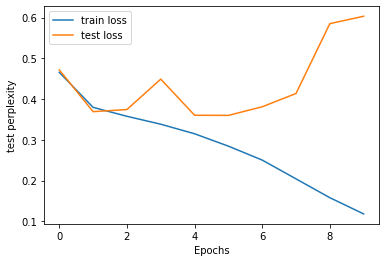

In [0]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yr, pred, pos_label=1)
print("AUC : ",metrics.auc(fpr, tpr))

from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(yr,pred))

from sklearn.metrics import precision_score
print("precision : ",precision_score(yr, pred))

from sklearn.metrics import recall_score
print("recall : " ,recall_score(yr, pred) )

from sklearn.metrics import f1_score
print("F1 : ", f1_score(yr, pred))

import matplotlib.pyplot as plt
import numpy as np
import math
hist2=history.history
loss=hist2['loss']
val_loss=hist2['val_loss']
plt.xlabel('Epochs')
plt.ylabel('train loss')
plt.plot(loss)

plt.xlabel('Epochs')
plt.ylabel('test perplexity')
plt.plot(val_loss)
plt.legend(['train loss','test loss'])

## **20 epochs**

In [0]:
model2 = build_model()
sess = tf.Session()
# Instantiate variables
initialize_vars(sess)

history2 = model2.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=20,
    batch_size=100
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_1 (BertLayer)        (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [0]:
model2.save_weights('./bert-model_sent2.h5')
# model2.load_weights('./bert-model_sent2.h5')

In [0]:
predict2 = model2.predict([test_input_ids, test_input_masks, test_segment_ids])

In [0]:
pred = []
for t in predict2:
  if(t<0.5):
    pred.append(0)
  else :
    pred.append(1)

In [0]:
# yr = [np.where(t == np.max(t))[0][0] for t in test_labels]
yr = test_labels

In [0]:
test_labels

array([1, 1, 1, ..., 1, 1, 0])

AUC :  0.8230926779313876
accuracy :  0.8234
precision :  0.8025878003696858
recall :  0.8615079365079366
F1 :  0.8310047846889952


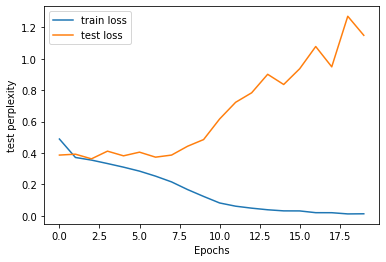

In [0]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yr, pred, pos_label=1)
print("AUC : ",metrics.auc(fpr, tpr))

from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(yr,pred))

from sklearn.metrics import precision_score
print("precision : ",precision_score(yr, pred))

from sklearn.metrics import recall_score
print("recall : " ,recall_score(yr, pred) )

from sklearn.metrics import f1_score
print("F1 : ", f1_score(yr, pred))

import matplotlib.pyplot as plt
import numpy as np
import math
hist2=history2.history
loss=hist2['loss']
val_loss=hist2['val_loss']
plt.xlabel('Epochs')
plt.ylabel('train loss')
plt.plot(loss)

plt.xlabel('Epochs')
plt.ylabel('test perplexity')
plt.plot(val_loss)
plt.legend(['train loss','test loss'])

## **50 epochs**

In [0]:
model50 = build_model()
sess = tf.Session()
# Instantiate variables
initialize_vars(sess)

history50 = model50.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=50,
    batch_size=100
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_2 (BertLayer)        (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [0]:
predict50 = model50.predict([test_input_ids, test_input_masks, test_segment_ids])

AUC :  0.8114375320020483
accuracy :  0.812
precision :  0.7758379888268156
recall :  0.8817460317460317
F1 :  0.825408618127786


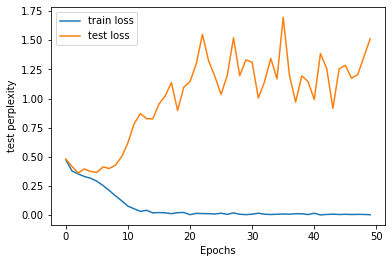

In [0]:
pred = []
for t in predict50:
  if(t<0.5):
    pred.append(0)
  else :
    pred.append(1)

yr = test_labels

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yr, pred, pos_label=1)
print("AUC : ",metrics.auc(fpr, tpr))

from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(yr,pred))

from sklearn.metrics import precision_score
print("precision : ",precision_score(yr, pred))

from sklearn.metrics import recall_score
print("recall : " ,recall_score(yr, pred) )

from sklearn.metrics import f1_score
print("F1 : ", f1_score(yr, pred))

import matplotlib.pyplot as plt
import numpy as np
import math
hist2=history50.history
loss=hist2['loss']
val_loss=hist2['val_loss']
plt.xlabel('Epochs')
plt.ylabel('train loss')
plt.plot(loss)

plt.xlabel('Epochs')
plt.ylabel('test perplexity')
plt.plot(val_loss)
plt.legend(['train loss','test loss'])

## **without preprocessing**

In [0]:
model_pre = build_model()
sess = tf.Session()
# Instantiate variables
initialize_vars(sess)

history_pre = model_pre.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=10,
    batch_size=100
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_3 (BertLayer)        (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [0]:
predict_pre = model_pre.predict([test_input_ids, test_input_masks, test_segment_ids])

AUC :  0.8469784785960367
accuracy :  0.847
precision :  0.8415064731267163
recall :  0.8559457302474063
F1 :  0.8486646884272997


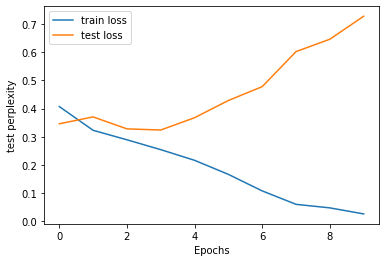

In [0]:
pred = []
for t in predict_pre:
  if(t<0.5):
    pred.append(0)
  else :
    pred.append(1)

yr = test_labels

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yr, pred, pos_label=1)
print("AUC : ",metrics.auc(fpr, tpr))

from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(yr,pred))

from sklearn.metrics import precision_score
print("precision : ",precision_score(yr, pred))

from sklearn.metrics import recall_score
print("recall : " ,recall_score(yr, pred) )

from sklearn.metrics import f1_score
print("F1 : ", f1_score(yr, pred))

import matplotlib.pyplot as plt
import numpy as np
import math
hist2=history_pre.history
loss=hist2['loss']
val_loss=hist2['val_loss']
plt.xlabel('Epochs')
plt.ylabel('train loss')
plt.plot(loss)

plt.xlabel('Epochs')
plt.ylabel('test perplexity')
plt.plot(val_loss)
plt.legend(['train loss','test loss'])

## **بخش امتیازی**

In [0]:
def build_model2(): 
    in_id = tf.keras.layers.Input(shape=(128,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(128,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(128,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BertLayer(n_fine_tune_layers=5)(bert_inputs)
    dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
    tf.keras.layers.Dropout(0.3)
    dense2 = tf.keras.layers.Dense(768, activation='relu')(dense)
    tf.keras.layers.Dropout(0.3)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense2)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    ada = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=ada, metrics=['accuracy'])
    model.summary()
    
    return model

In [0]:
model3 = build_model2()
sess = tf.Session()
# Instantiate variables
initialize_vars(sess)

history3 = model3.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=10,
    batch_size=100
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_6 (BertLayer)        (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [0]:
predict3 = model3.predict([test_input_ids, test_input_masks, test_segment_ids])

AUC :  0.7666064741177644
accuracy :  0.7716
precision :  0.7091015510681885
recall :  0.9424348502528199
F1 :  0.8092852371409485


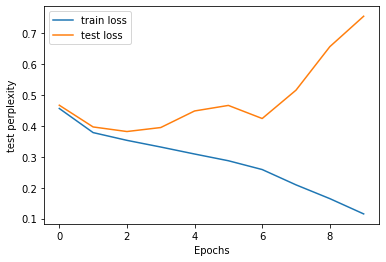

In [0]:
pred = []
for t in predict3:
  if(t<0.5):
    pred.append(0)
  else :
    pred.append(1)

yr = test_labels

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yr, pred, pos_label=1)
print("AUC : ",metrics.auc(fpr, tpr))

from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(yr,pred))

from sklearn.metrics import precision_score
print("precision : ",precision_score(yr, pred))

from sklearn.metrics import recall_score
print("recall : " ,recall_score(yr, pred) )

from sklearn.metrics import f1_score
print("F1 : ", f1_score(yr, pred))

import matplotlib.pyplot as plt
import numpy as np
import math
hist2=history3.history
loss=hist2['loss']
val_loss=hist2['val_loss']
plt.xlabel('Epochs')
plt.ylabel('train loss')
plt.plot(loss)

plt.xlabel('Epochs')
plt.ylabel('test perplexity')
plt.plot(val_loss)
plt.legend(['train loss','test loss'])

In [0]:
def build_model5(): 
    in_id = tf.keras.layers.Input(shape=(128,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(128,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(128,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BertLayer(n_fine_tune_layers=5)(bert_inputs)
    dense = tf.keras.layers.Dense(32, activation='relu')(bert_output)
    dense2 = tf.keras.layers.Dense(64, activation='relu')(dense)
    dense3 = tf.keras.layers.Dense(128, activation='relu')(dense2)
    dense4 = tf.keras.layers.Dense(256, activation='relu')(dense3)
    dense5 = tf.keras.layers.Dense(768, activation='relu')(dense4)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense5)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    ada = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=ada, metrics=['accuracy'])
    model.summary()
    
    return model

In [13]:
model5 = build_model5()
sess = tf.Session()
# Instantiate variables
initialize_vars(sess)

history5 = model5.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=10,
    batch_size=350
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_1 (BertLayer)        (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [0]:
predict5 = model5.predict([test_input_ids, test_input_masks, test_segment_ids])

AUC :  0.828522441017449
accuracy :  0.8284
precision :  0.784375
recall :  0.9050480769230769
F1 :  0.8404017857142858


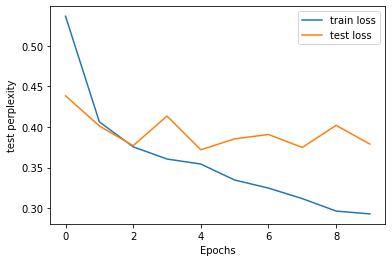

In [15]:
pred = []
for t in predict5:
  if(t<0.5):
    pred.append(0)
  else :
    pred.append(1)

yr = test_labels

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yr, pred, pos_label=1)
print("AUC : ",metrics.auc(fpr, tpr))

from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(yr,pred))

from sklearn.metrics import precision_score
print("precision : ",precision_score(yr, pred))

from sklearn.metrics import recall_score
print("recall : " ,recall_score(yr, pred) )

from sklearn.metrics import f1_score
print("F1 : ", f1_score(yr, pred))

import matplotlib.pyplot as plt
import numpy as np
import math
hist2=history5.history
loss=hist2['loss']
val_loss=hist2['val_loss']
plt.xlabel('Epochs')
plt.ylabel('train loss')
plt.plot(loss)

plt.xlabel('Epochs')
plt.ylabel('test perplexity')
plt.plot(val_loss)
plt.legend(['train loss','test loss'])

In [0]:
def build_model7(): 
    in_id = tf.keras.layers.Input(shape=(128,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(128,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(128,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BertLayer(n_fine_tune_layers=5)(bert_inputs)
    dense = tf.keras.layers.Dense(16, activation='relu')(bert_output)
    dense2 = tf.keras.layers.Dense(32, activation='relu')(dense)
    dense3 = tf.keras.layers.Dense(64, activation='relu')(dense2)
    dense4 = tf.keras.layers.Dense(128, activation='relu')(dense3)
    dense5 = tf.keras.layers.Dense(256, activation='relu')(dense4)
    dense6 = tf.keras.layers.Dense(512, activation='relu')(dense5)
    dense7 = tf.keras.layers.Dense(768, activation='relu')(dense6)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense7)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    ada = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=ada, metrics=['accuracy'])
    model.summary()
    
    return model

In [18]:
model7 = build_model7()
sess = tf.Session()
# Instantiate variables
initialize_vars(sess)

history7 = model7.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=10,
    batch_size=250
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_3 (BertLayer)        (None, 768)          108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [0]:
predict7 = model7.predict([test_input_ids, test_input_masks, test_segment_ids])

AUC :  0.7948557948308349
accuracy :  0.7946
precision :  0.7227782832878374
recall :  0.9547275641025641
F1 :  0.8227170723286725


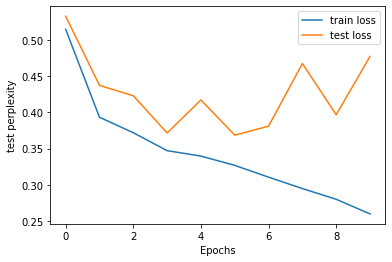

In [21]:
pred = []
for t in predict7:
  if(t<0.5):
    pred.append(0)
  else :
    pred.append(1)

yr = test_labels

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yr, pred, pos_label=1)
print("AUC : ",metrics.auc(fpr, tpr))

from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(yr,pred))

from sklearn.metrics import precision_score
print("precision : ",precision_score(yr, pred))

from sklearn.metrics import recall_score
print("recall : " ,recall_score(yr, pred) )

from sklearn.metrics import f1_score
print("F1 : ", f1_score(yr, pred))

import matplotlib.pyplot as plt
import numpy as np
import math
hist2=history7.history
loss=hist2['loss']
val_loss=hist2['val_loss']
plt.xlabel('Epochs')
plt.ylabel('train loss')
plt.plot(loss)

plt.xlabel('Epochs')
plt.ylabel('test perplexity')
plt.plot(val_loss)
plt.legend(['train loss','test loss'])